In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using Gurobi
using PiecewiseLinearOpt
using VegaLite, VegaDatasets
using FileIO

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [2]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [3]:
innovations = CSV.File("./data-case-roadmap/innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise.csv",header=1,delim=",") |> DataFrame
compromise[67:240,:GHG_ElecInd].+=1
compromise[100:165,:GHG_ElecInd].+=0.5
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations[3,2]=156
#innovations[2,6]=7
#compromise[!,3]=compromise[!,3]/2
#innovations[2,2]=175
#innovations[2,2]=205
#innovations[2,3]=2
#innovations[1,3]=3
#innovations[4,2]=108

#innovations[1,2]=185
#innovations[3,3]=2
innovations
#CSV.write("innovations.csv",innovations)

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,121.08,3,8.32,8.84,0.65,9.9,9.65,0
2,2,103.22,3,8.32,8.84,0.65,9.9,9.65,0
3,3,156.0,1,4.6,1.34,2.04,0.12,8.86,0
4,4,90.68,1,5.48,7.62,3.34,5.05,1.1,0
5,5,77.52,3,9.94,2.38,7.94,3.82,5.44,0
6,6,98.51,2,4.44,1.21,5.09,6.52,8.67,0
7,7,121.59,3,4.44,1.21,5.09,6.52,8.67,0
8,8,122.1,1,4.6,1.34,2.04,0.12,8.86,0
9,9,122.26,2,5.48,7.62,3.34,5.05,1.1,0


In [4]:

compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [5]:
mapki[10,2]=240
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [6]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

In [7]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],digits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],digits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),digits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [8]:
inn_reg = CSV.File("./data-case-roadmap/inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./data-case-roadmap/inn_xrang.csv",header=1,delim=",") |> DataFrame
inn_yrang = CSV.File("./data-case-roadmap/inn_yrang.csv",header=1,delim=",") |> DataFrame
inn_yrang[!,"Y0"]=-1*(innovations[!,"RL"].-5)
inn_yrang

,Column1,Y0,Y1,Y2,Y3,Y4,Y5
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,2,1.81274,2.24624,3.227,4.48808,6.08818
2,2,2,1.81274,2.24624,3.227,4.48808,6.08818
3,3,4,3.69121,4.57345,6.60407,9.45836,13.0855
4,4,4,3.72014,4.11985,5.30286,7.01497,9.24516
5,5,2,2.35761,3.16539,4.30352,5.69014,7.54168
6,6,3,2.68846,3.30768,4.82566,6.93351,9.60059
7,7,2,2.38591,3.62069,5.21565,7.22296,9.61039
8,8,4,3.69121,4.57345,6.60407,9.45836,13.0855
9,9,3,3.8944,4.79125,5.90838,7.44012,9.19717


In [9]:
tau=[0,5,10,15,20,25,30]

7-element Vector{Int64}:
  0
  5
 10
 15
 20
 25
 30

In [10]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [11]:
function tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,circularity_target)
    
    rdmap= Model(Gurobi.Optimizer)
    #set_optimizer_attribute(rdmap, "MaxTime", 100)
    #set_optimizer_attribute(rdmap, "optCR", 0.2)
    set_optimizer_attribute(rdmap, "NonConvex", 2)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise),tt=1:7],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise),tt=1:7] ≤ 5)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise),tt=1:7] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations),tt=1:7],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations),tt=1:7] ≤ 5)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations),tt=1:7] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050[tt=1:7])
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030[tt=1:7] ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030[tt=1:7] ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030[tt=1:7] ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations),tt=1:7] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise),tt=1:7]≥ 0)
    @variable(rdmap,co2_corrected[k=1:nrow(compromise),tt=1:7]≥ 0)

    for i in 1:nrow(innovations)
        for tt in 1:7
            f_fit[i,tt] = piecewiselinear(rdmap, tau[tt]+ti[i,tt], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
        end
    end
            
    
    for k in 1:nrow(compromise)
        for tt in 1:7
            co2_factor[k,tt] = (piecewiselinear(rdmap, tau[tt]+tk[k,tt], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:2])[:,1]))
    
        end
    end
    
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
        compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(co2_factor[k,tt])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1,tt=1:7], sum(yk[k,tt] for k=1:mapki[i,2])≤yi[i,tt])
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], sum(yk[k,tt] for k=mapki[i-1,2]:mapki[i,2])≤yi[i,tt])
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1,tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:7], 5*yi[i,tt] ≥ ti[i,tt])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], 5*yk[k,tt] ≥ tk[k,tt])
    
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:6], yi[i,tt+1] ≥ yi[i,tt])
    @constraint(rdmap, [i=1:nrow(mapki),tt=2:7],ti[i,tt]≤ 5*( yi[i,tt]-yi[i,tt-1]))
    
    #if compromise chosen across boundary tk=0
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5*( yk[k,tt]-yk[k,tt-1]))
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5000*( xk[k,tt]-xk[k,tt-1]))
    #time of change has to be same
    #=   
    @variables(rdmap,begin 
                    u1[k=1:nrow(compromise),tt=2:7], Bin
                    u2[k=1:nrow(compromise),tt=2:7], Bin
                    u0[k=1:nrow(compromise),tt=2:7], Bin
        end)
    
    
    for i in 2:nrow(mapki)
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    end
    
    i=1
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])  
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    =#  
    
    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], yk[k,tt] ≥ xk[k,tt])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1i
    @constraint(rdmap,[tt=1:7], sum(xk[k,tt] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    @constraint(rdmap,[tt=7],co2_2050[tt]==sum(xk[k,7]*co2_corrected[k,7] for k in 1:nrow(compromise))
        + (1-sum(xk[k,7] for k in 1:nrow(compromise)))*initial[1,3])
    
    #tk < 30
    #@variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    #@constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
    #   + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap,[tt=3:7], recycl_2030[tt]==sum(xk[k,tt]*compromise[k,5] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap,[tt=3:7], comp_2030[tt]==sum(xk[k,tt]*compromise[k,6] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ w1k[k=1:nrow(compromise),tt=2:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≥ 5*xk[k,tt-1]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ 5*xk[k,tt-1])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ tk[k,tt])
    
    @variable(rdmap,0 ≤ w2k[k=1:nrow(compromise),tt=1:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≥ 5*xk[k,tt]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ 5*xk[k,tt])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ tk[k,tt])
    
    
    
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5-tk[k,tt])*xk[k,tt]*
    #                        (initial[1,3]-co2_corrected[k,tt]) for k in 1:nrow(compromise)) for tt in 1:6))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5*xk[k,tt]-wk[k,tt])*(initial[1,3]-co2_corrected[k,tt]) 
    #                for k in 1:nrow(compromise)) for tt in 1:7))
    
    @constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
                        -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])+(w2k[k,tt]*co2_corrected[k,tt])
                        + 5*initial[1,3]*(sum(xk[k,tt-1] for k in 1:nrow(compromise))-sum(xk[k,tt] for k in 1:nrow(compromise)))
                        for k in 1:nrow(compromise)) for tt in 2:7))
    
    #@constraint(rdmap, 120*0.001*co2_tot ≤ 360)
    

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050[7] ≤ co2_target)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    @constraint(rdmap,[tt=3:7], recycl_2030[tt] + comp_2030[tt] ≥ circularity_target)
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.45)
    
    #@constraint(rdmap,[k=1:25,tt=3:7],tk[k,tt]==0)


    #investment cost
    @constraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
                for i in 1:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
    
    #operating cost
    @variable(rdmap,cost_op ≥ 0)
    @constraint(rdmap,cost_op == sum(sum(xk[k,tt]*compromise[k,9]*0.968^(-1*tau[tt]) for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,7]*0.968^(-1*tau[tt]) for tt in 1:7))

    
    @constraint(rdmap, [i=1:nrow(innovations),tt=1:7],s[i,tt]==f_fit[i,tt])
    
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    
    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    #120*0.001*co2_tot+
    @objective(rdmap,Min,120*0.001*co2_tot+cost_inn+cost_op)
    #120*0.001*co2_tot+
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(co2_corrected), JuMP.value.(co2_factor)
end




tech_roadmap_mccormick_peicewise_iam_multipd (generic function with 1 method)

In [12]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, co2fac, cc=tech_roadmap_mccormick_peicewise_iam_multipd(0.5,0.75)
yi


Academic license - for non-commercial use only - expires 2022-11-07
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 30574 rows, 29331 columns and 109143 nonzeros
Model fingerprint: 0x793033ac
Model has 3 quadratic constraints
Variable types: 22331 continuous, 7000 integer (7000 binary)
Coefficient statistics:
  Matrix range     [6e-03, 5e+01]
  QMatrix range    [1e+00, 2e+02]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [1e-01, 1e+00]
  Bounds range     [3e-01, 1e+01]
  RHS range        [1e-01, 4e+01]
  QRHS range       [8e+00, 1e+04]
Presolve removed 10481 rows and 13636 columns
Presolve time: 0.19s
Presolved: 38726 rows, 20385 columns, 152483 nonzeros
Presolved model has 4560 bilinear constraint(s)
Variable types: 16914 continuous, 3471 integer (3471 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time:

10×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

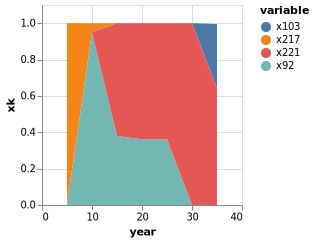

In [136]:
transpose(xk)
df1=DataFrame(xk',:auto)
df1[!,:year] = 5*collect(1:7)
df1=df1[!, any.(>(0), eachcol(df1))]
sNames="compromise ".*string.(collect(1:length(xk[:,1])))
#rename!(df1,[:x92,:x103,:x217,:x221] .=> [:pyLDPE1,:pyLDPE11,:alcPLA2,:alcPLA6])

comp=df1 |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="xk"}, color="variable:n",legend=:sNames) 
#save("./result-case-roadmap/compromise-roadmap.svg", comp)
comp


In [81]:
mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,29,MSW pyrolysis to small olefins
2,2,52,Source Segregation
3,3,66,AI robot segregation
4,4,91,LABS from PE
5,5,113,Pyrolysis of LDPE
6,6,140,Pyrolysis of HDPE
7,7,165,Pyrolysis of PP
8,8,193,Recycling back to PLA usin Clay
9,9,215,Alkaline hydrolysis of PLA


In [82]:
xk

240×7 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [83]:
ti  

10×7 Matrix{Float64}:
 0.0          -3.55271e-14  -2.84217e-14  …   3.55271e-15  -4.61853e-14
 0.0          -3.55271e-14  -2.84217e-14      0.0          -7.81597e-14
 0.0           0.0          -2.84217e-14      0.0           0.0
 0.0           0.0          -4.26326e-14      0.0           0.0
 0.0           0.0          -3.55271e-15     -1.42109e-14  -4.44089e-15
 8.88178e-15   0.0          -2.84217e-14  …  -8.88178e-15  -3.55271e-14
 0.0          -7.10543e-15   0.0             -2.4869e-14   -8.43769e-15
 0.0           0.0          -2.84217e-14      0.0           0.0
 0.0           7.10543e-15  -1.95399e-14     -3.55271e-14  -2.84217e-14
 5.0           0.0          -4.26326e-14     -5.32907e-15   0.0

In [84]:
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp,GHG_ElecInd,GHG_Trans,OCost
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,15.0711,0.621,0.0,0.0,0.499,0.122,3.4294
2,2,1,2.7837,0.3955,0.661676,0.0,0.47,0.127,1.1203
3,3,1,10.0834,0.41,0.0,1.0,0.56,0.111,0.65
4,4,1,8.9103,0.4132,0.0,0.958953,0.54,0.104,0.67
5,5,1,4.0,0.4546,0.0,0.0,0.54,0.139,0.7
6,6,1,4.1434,0.5081,0.0,0.0,0.57,0.12,0.7
7,7,1,7.1535,0.4218,0.0,0.854318,0.5,0.114,0.7
8,8,1,4.1374,0.5081,0.0,0.0,0.46,0.116,0.7
9,9,1,7.1535,0.4218,0.0,0.854318,0.52,0.132,0.7


In [85]:
s

10×7 Matrix{Float64}:
 2.0      1.93097  2.08861  2.24624  2.60288  2.95952  3.36712
 2.0      1.93097  2.08861  2.24624  2.60288  2.95952  3.36712
 4.0      3.69121  4.08332  4.47542  5.18264  5.99488  6.92121
 4.0      3.72014  3.89779  4.07544  4.47475  4.94796  5.49309
 2.0      2.15894  2.31787  2.62687  2.98589  3.44992  4.01899
 3.0      2.68846  2.96366  3.23887  3.76307  4.37027  5.05987
 2.0      2.25727  2.63287  3.12678  3.62069  4.32956  5.03843
 4.0      3.69121  4.08332  4.47542  5.18264  5.99488  6.92121
 3.0      3.29813  3.59627  3.8944   4.34283  4.79125  5.42961
 3.72014  3.72014  3.89779  4.07544  4.47475  4.94796  5.49309

In [86]:
df1

,x92,x103,x217,x221,year
,Float64,Float64,Float64,Float64,Int64
1,0.0,0.0,1.0,0.0,5
2,0.95,0.0,0.05,0.0,10
3,0.379343,0.0,0.0,0.620657,15
4,0.360979,0.0,0.0,0.639021,20
5,0.360979,0.0,0.0,0.639021,25
6,0.0,0.0,0.0,1.0,30
7,0.0,0.354483,0.0,0.640924,35


In [87]:
iam_model

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


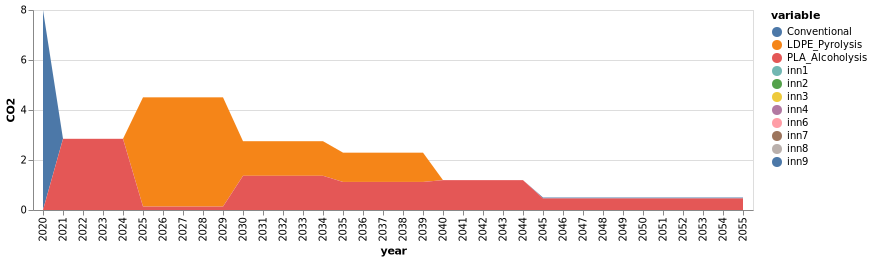

In [110]:
function conventional(t)
    return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=mapki[i-1,2]:mapki[i,2])
    end
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end
j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end


sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]

rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

save("./result-case-roadmap/co2-roadmap.svg", co2_inn)
co2_inn



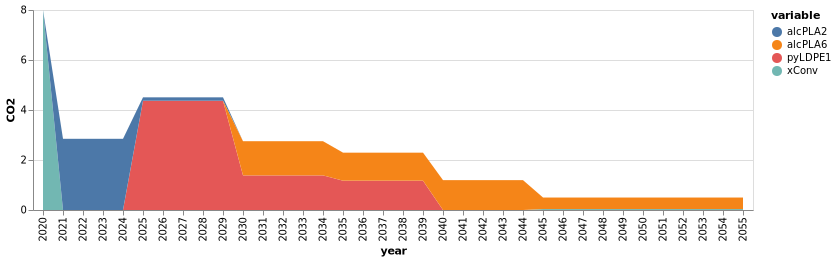

In [139]:
#only for this result

function conventional(t)
    return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(k1,t)
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
    end
end

conv=zeros(51)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(compromise),51)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:51
    if 0 ≤ t ≤ 5
        j=1
    elseif 6 ≤ t ≤ 10
        j=2
    elseif 6 ≤ t ≤ 10
        j=3
    elseif 11 ≤ t ≤ 15
        j=4
    elseif 16 ≤ t ≤ 20
        j=5
    elseif 21 ≤ t ≤ 25
        j=6
    else
        j=7
    end
        
    conv[t]=conventional(j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(k,j)
    end
end


sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(conv',inn_co2)',:auto)


df=df[1:36,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:36]
rename!(df,[:x1,:x93,:x218,:x222] .=> [:xConv,:pyLDPE1,:alcPLA2,:alcPLA6])


#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

#save("./result-case-roadmap/co2-roadmap.svg", co2_inn)
co2_inn



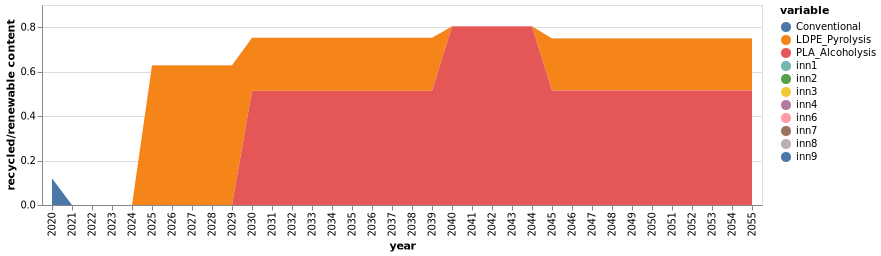

In [111]:
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end
sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]


#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 


rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 

save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn


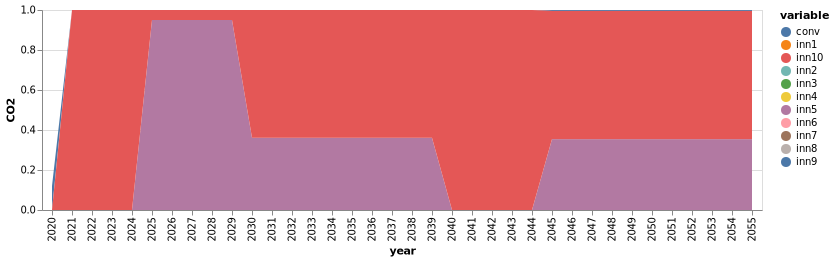

In [23]:
function conventional(t)
    return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i,t)
    if i==1
        return sum(JuMP.values.(xk)[k,t] for k=1:mapki[i,2])
    else
        return sum(JuMP.values.(xk)[k,t] for k=mapki[i-1,2]:mapki[i,2] )
    end
end

conv=zeros(51)

conv[1]=initial[1,5]
inn_co2=zeros(nrow(innovations),51)

for inn in 1:nrow(innovations)
    inn_co2[inn,1]=0
end

j=0
for i in 2:51
    if 0 ≤ i ≤ 5
        j=1
    elseif 6 ≤ i ≤ 10
        j=2
    elseif 6 ≤ i ≤ 10
        j=3
    elseif 11 ≤ i ≤ 15
        j=4
    elseif 16 ≤ i ≤ 20
        j=5
    elseif 21 ≤ i ≤ 25
        j=6
    else
        j=7
    end
        
    conv[i]=conventional(j)
    for inn in 1:nrow(innovations)
        inn_co2[inn,i]=innovation(inn,j)
    end
end

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df=df[1:36,:]
df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

In [24]:
#=
#cost objective
#@NLconstraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
#            for i in 2:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
#linearization
@variable(rdmap,0≤p[i=1:nrow(innovations),tt=2:7]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤5*(yi[i,tt]-yi[i,tt-1]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=2:7],p[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt]-yi[i,tt-1])))

@variable(rdmap,0≤q[i=1:nrow(innovations),tt=1:1]≤5)
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(yi[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≤(f_fit[i,tt]))
@constraint(rdmap,[i=1:nrow(innovations),tt=1:1],q[i,tt]≥(f_fit[i,tt])-5*(1-(yi[i,tt])))

@constraint(rdmap,cost_inn == sum(sum(ci[i]*p[i,tt] for i in 2:nrow(innovations)) for tt in 2:7) +
                                sum(ci[i]*q[i,1] for i in 1:nrow(innovations)))

#http://yetanothermathprogrammingconsultant.blogspot.com/2008/05/multiplication-of-continuous-and-binary.html

=#
